# LangGraph 완벽 입문 가이드 🚀

## 📚 LangGraph란 무엇인가?

LangGraph는 **그래프 기반 워크플로우**를 사용하여 AI 애플리케이션을 만드는 프레임워크입니다.

### 🤔 왜 LangGraph를 사용해야 할까요?

1. **명확한 흐름 제어**: 각 단계(노드)를 명확하게 정의하고 관리할 수 있습니다
2. **유연한 라우팅**: 조건에 따라 다른 경로로 흐름을 제어할 수 있습니다
3. **상태 관리**: 각 단계마다 상태를 추적하고 관리할 수 있습니다
4. **시각화**: 복잡한 워크플로우를 다이어그램으로 쉽게 표현할 수 있습니다

### 🎯 핵심 개념

- **노드(Node)**: 각 작업 단계를 나타내는 함수
- **엣지(Edge)**: 노드 간의 연결과 흐름
- **상태(State)**: 워크플로우 전체에서 공유되는 데이터
- **그래프(Graph)**: 노드와 엣지로 구성된 전체 워크플로우

---

## 🎓 실습 프로젝트: 텍스트 분석 파이프라인

이 튜토리얼에서는 **3단계 텍스트 분석 파이프라인**을 만들어봅니다:

```
입력 텍스트 → [1단계: 분류] → [2단계: 개체명 추출] → [3단계: 요약] → 결과
```

1. **텍스트 분류**: 뉴스, 블로그, 연구논문, 기타 중 하나로 분류
2. **개체명 추출**: 인명, 기관명, 지명 등 주요 개체 추출
3. **텍스트 요약**: 핵심 내용을 한 문장으로 요약

## 📦 1단계: 필요한 라이브러리 임포트

### 각 라이브러리의 역할 설명

In [1]:
# ==================== 기본 라이브러리 ====================
import os  # 운영체제와 상호작용 (환경변수, 파일시스템 등)
from typing import TypedDict, List  # 타입 힌팅으로 코드의 안정성과 가독성 향상

# ==================== LangGraph 핵심 ====================
# StateGraph: 상태를 관리하는 그래프를 만드는 핵심 클래스
#   - 각 노드는 상태를 읽고 수정할 수 있습니다
#   - 전체 워크플로우의 흐름을 정의합니다
from langgraph.graph import StateGraph, END
# END: 그래프의 종료 지점을 나타내는 특수 노드

# ==================== LangChain 컴포넌트 ====================
# PromptTemplate: AI에게 보낼 프롬프트를 템플릿화
#   - 변수를 사용하여 동적으로 프롬프트 생성
#   - 일관된 형식의 프롬프트 관리
from langchain.prompts import PromptTemplate

# ChatOpenAI: OpenAI의 GPT 모델과 통신하는 클래스
#   - API 호출을 간편하게 처리
#   - 응답을 표준화된 형식으로 받음
from langchain_openai import ChatOpenAI

# HumanMessage: 사용자 메시지를 나타내는 클래스
#   - AI와의 대화에서 사람의 메시지를 구조화
from langchain.schema import HumanMessage

# ==================== 시각화 도구 ====================
# MermaidDrawMethod: Mermaid 문법으로 그래프를 시각화
#   - 워크플로우를 다이어그램으로 표현
from langchain_core.runnables.graph import MermaidDrawMethod

# ==================== Jupyter 디스플레이 ====================
# display, Image: 노트북에 이미지를 표시하는 함수
from IPython.display import display, Image

# ==================== 환경변수 관리 ====================
# load_dotenv: .env 파일에서 환경변수를 로드
#   - API 키 같은 민감한 정보를 코드에서 분리
from dotenv import load_dotenv

print("✅ 모든 라이브러리 임포트 완료!")

✅ 모든 라이브러리 임포트 완료!


### 💡 왜 이런 구조로 임포트할까?

1. **모듈화**: 각 라이브러리는 특정 역할만 수행합니다
2. **재사용성**: 필요한 기능만 선택적으로 임포트합니다
3. **유지보수**: 코드를 논리적 단위로 분리하여 관리가 쉽습니다

## 🔑 2단계: API 키 설정

### 환경변수를 사용하는 이유

1. **보안**: API 키를 코드에 직접 노출하지 않습니다
2. **관리**: 여러 프로젝트에서 같은 키를 재사용할 수 있습니다
3. **공유**: 코드를 공유할 때 키를 제외할 수 있습니다

In [2]:
# .env 파일에서 환경변수 로드
# .env 파일 예시:
# OPENAI_API_KEY=sk-your-api-key-here
load_dotenv()

# 환경변수에서 API 키를 가져와서 설정
# os.environ은 시스템의 환경변수를 저장하는 딕셔너리입니다
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# API 키가 제대로 로드되었는지 확인 (보안을 위해 일부만 표시)
api_key = os.getenv('OPENAI_API_KEY')
if api_key:
    print(f"✅ API 키 로드 성공! (앞 10자: {api_key[:10]}...)")
else:
    print("❌ API 키를 찾을 수 없습니다. .env 파일을 확인하세요!")

✅ API 키 로드 성공! (앞 10자: sk-proj--e...)


## 🏗️ 3단계: 상태(State) 정의와 LLM 초기화

### 상태(State)란?

상태는 워크플로우 전체에서 공유되는 **데이터 저장소**입니다.
각 노드는 상태를 읽고, 수정하고, 다음 노드로 전달합니다.

### TypedDict를 사용하는 이유

1. **타입 안정성**: 각 필드의 타입을 명시하여 오류를 방지합니다
2. **자동완성**: IDE에서 자동완성 기능을 사용할 수 있습니다
3. **문서화**: 코드만으로도 데이터 구조를 이해할 수 있습니다

In [5]:
# ==================== 상태 클래스 정의 ====================
class State(TypedDict):
    """
    워크플로우의 상태를 정의하는 클래스
    
    각 필드의 의미:
    - text: 분석할 원본 텍스트 (입력)
    - classification: 텍스트의 분류 결과 (뉴스/블로그/연구/기타)
    - entities: 추출된 개체명 리스트 (인명, 기관명, 지명 등)
    - summary: 텍스트의 요약 (한 문장)
    """
    text: str              # 원본 텍스트
    classification: str    # 분류 결과
    entities: List[str]    # 개체명 리스트
    summary: str           # 요약문

# ==================== LLM 초기화 ====================
# ChatOpenAI: OpenAI의 GPT 모델을 사용하는 클래스
llm = ChatOpenAI(
    model="gpt-4o-mini",  # 모델 선택: gpt-4o-mini는 빠르고 비용 효율적
    temperature=0         # temperature=0: 가장 확률이 높은 답변만 생성 (일관성 ↑)
                          # temperature=1: 창의적이고 다양한 답변 생성 (무작위성 ↑)
)

print("✅ 상태 클래스와 LLM 초기화 완료!")
print(f"   사용 모델: {llm.model_name}")
print(f"   Temperature: {llm.temperature}")

✅ 상태 클래스와 LLM 초기화 완료!
   사용 모델: gpt-4o-mini
   Temperature: 0.0


### 🎯 Temperature 매개변수 이해하기

Temperature는 AI의 **창의성 vs 일관성**을 조절합니다:

| Temperature | 특징 | 사용 예시 |
|-------------|------|----------|
| 0.0 | 가장 확률 높은 답변만 선택 (결정론적) | 분류, 번역, 요약 |
| 0.5 | 적당한 창의성 | 일반적인 대화 |
| 1.0 | 매우 창의적이고 다양한 답변 | 스토리 생성, 브레인스토밍 |

이 프로젝트에서는 **일관된 결과**가 중요하므로 temperature=0을 사용합니다.

## 🔧 4단계: 노드 함수 정의

### 노드(Node)란?

노드는 워크플로우의 **각 작업 단계**를 나타냅니다.
- 입력: 현재 상태(State)
- 처리: 특정 작업 수행
- 출력: 업데이트된 상태의 일부

### 3개의 노드 구조

```
classification_node     → 텍스트를 카테고리로 분류
       ↓
entity_extraction_node  → 중요한 개체명 추출
       ↓
summarization_node      → 핵심 내용 요약
```

In [6]:
# ==================== 노드 1: 텍스트 분류 ====================
def classification_node(state: State) -> dict:
    """
    텍스트를 4가지 카테고리 중 하나로 분류합니다.
    
    왜 이렇게 만들까?
    1. PromptTemplate: 프롬프트를 템플릿화하여 재사용성을 높입니다
    2. HumanMessage: LangChain의 표준 메시지 형식을 사용합니다
    3. strip(): 응답의 앞뒤 공백을 제거하여 깔끔한 결과를 얻습니다
    
    Args:
        state: 현재 워크플로우의 상태
    
    Returns:
        dict: {"classification": "News"} 형태로 분류 결과 반환
    """
    print("\n🔍 [노드 1] 텍스트 분류 시작...")
    
    # 프롬프트 템플릿 생성
    # {text}는 실행 시 실제 텍스트로 치환됩니다
    prompt = PromptTemplate(
        input_variables=["text"],  # 템플릿에 사용할 변수 목록
        template="""
다음 텍스트를 분류하세요. 반드시 아래 4가지 중 하나를 선택하세요:
- News (뉴스)
- Blog (블로그)
- Research (연구논문)
- Other (기타)

텍스트:
{text}

분류 결과 (하나만 답변):
        """
    )
    
    # 프롬프트에 실제 텍스트를 넣어서 메시지 생성
    message = HumanMessage(content=prompt.format(text=state["text"]))
    
    # LLM에 메시지를 보내고 응답 받기
    classification = llm.invoke([message]).content.strip()
    
    print(f"   ✅ 분류 완료: {classification}")
    
    # 결과를 딕셔너리로 반환 (상태의 classification 필드가 업데이트됨)
    return {"classification": classification}


# ==================== 노드 2: 개체명 추출 ====================
def entity_extraction_node(state: State) -> dict:
    """
    텍스트에서 중요한 개체명을 추출합니다.
    
    개체명(Named Entity)이란?
    - 인명: 홍길동, Steve Jobs, 김철수
    - 기관명: 삼성전자, Apple, 서울대학교
    - 지명: 서울, San Francisco, 한강
    
    왜 split(", ")를 사용할까?
    - LLM이 "Apple, Google, Microsoft" 형태로 응답하므로
    - 쉼표로 분리하여 리스트로 변환합니다
    
    Args:
        state: 현재 워크플로우의 상태
    
    Returns:
        dict: {"entities": ["개체1", "개체2", ...]} 형태로 반환
    """
    print("\n🏢 [노드 2] 개체명 추출 시작...")
    
    prompt = PromptTemplate(
        input_variables=["text"],
        template="""
다음 텍스트에서 주요 개체명을 추출하세요:
- 인명 (사람 이름)
- 기관명 (회사, 조직, 학교 등)
- 지명 (도시, 국가, 장소 등)

결과는 쉼표로 구분하여 나열하세요.
예시: Apple, Steve Jobs, Cupertino

텍스트:
{text}

개체명:
        """
    )
    
    message = HumanMessage(content=prompt.format(text=state["text"]))
    
    # LLM 응답을 받아서 쉼표로 분리하여 리스트로 변환
    entities_str = llm.invoke([message]).content.strip()
    entities = [e.strip() for e in entities_str.split(",")]  # 각 항목의 공백도 제거
    
    print(f"   ✅ 추출 완료: {len(entities)}개 개체명 발견")
    for i, entity in enumerate(entities, 1):
        print(f"      {i}. {entity}")
    
    return {"entities": entities}


# ==================== 노드 3: 텍스트 요약 ====================
def summarization_node(state: State) -> dict:
    """
    텍스트를 한 문장으로 요약합니다.
    
    왜 "한 문장"으로 제한할까?
    1. 명확성: 핵심만 전달합니다
    2. 일관성: 길이가 예측 가능합니다
    3. 효율성: 빠르게 내용을 파악할 수 있습니다
    
    Args:
        state: 현재 워크플로우의 상태
    
    Returns:
        dict: {"summary": "요약문"} 형태로 반환
    """
    print("\n📝 [노드 3] 텍스트 요약 시작...")
    
    prompt = PromptTemplate(
        input_variables=["text"],
        template="""
다음 텍스트를 **한 문장**으로 요약하세요.
핵심 내용만 간결하게 표현하세요.

텍스트:
{text}

요약:
        """
    )
    
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    
    print(f"   ✅ 요약 완료")
    print(f"   📄 {summary}")
    
    return {"summary": summary}


print("✅ 모든 노드 함수 정의 완료!")
print("   - classification_node: 텍스트 분류")
print("   - entity_extraction_node: 개체명 추출")
print("   - summarization_node: 텍스트 요약")

✅ 모든 노드 함수 정의 완료!
   - classification_node: 텍스트 분류
   - entity_extraction_node: 개체명 추출
   - summarization_node: 텍스트 요약


### 💡 노드 설계 원칙

1. **단일 책임**: 각 노드는 하나의 작업만 수행합니다
2. **상태 의존성**: 노드는 상태를 읽고 필요한 부분만 업데이트합니다
3. **독립성**: 각 노드는 독립적으로 테스트하고 수정할 수 있습니다
4. **재사용성**: 다른 워크플로우에서도 같은 노드를 재사용할 수 있습니다

## 🏗️ 5단계: 워크플로우 구축

### 그래프 구축 과정

```
1. StateGraph 생성 → 상태 구조 정의
2. 노드 추가 → 각 작업 단계 등록
3. 엣지 추가 → 노드 간 연결
4. 컴파일 → 실행 가능한 앱으로 변환
```

### 왜 이런 순서로 구축할까?

1. **명확한 구조**: 상태 → 노드 → 연결 순서로 점진적으로 구축
2. **유연성**: 나중에 노드를 추가하거나 연결을 변경하기 쉬움
3. **디버깅**: 각 단계를 확인하면서 구축할 수 있음

In [7]:
print("🏗️ 워크플로우 구축 시작...\n")

# ==================== 1. StateGraph 생성 ====================
# StateGraph: 상태를 관리하는 그래프 객체
# State 클래스를 전달하여 어떤 데이터를 추적할지 정의
workflow = StateGraph(State)
print("✅ 1단계: StateGraph 생성 완료")

# ==================== 2. 노드 추가 ====================
# add_node("노드이름", 실행할_함수)
# 노드 이름은 워크플로우에서 해당 단계를 식별하는 ID입니다
workflow.add_node("classification_node", classification_node)
print("✅ 2-1단계: classification_node 추가")

workflow.add_node("entity_extraction", entity_extraction_node)
print("✅ 2-2단계: entity_extraction 추가")

workflow.add_node("summarization", summarization_node)
print("✅ 2-3단계: summarization 추가")

# ==================== 3. 엣지(흐름) 추가 ====================
# set_entry_point: 워크플로우의 시작점 설정
workflow.set_entry_point("classification_node")
print("\n✅ 3-1단계: 시작점 설정 (classification_node)")

# add_edge: 노드 간 연결 (A → B)
# "classification_node가 끝나면 entity_extraction으로 이동"
workflow.add_edge("classification_node", "entity_extraction")
print("✅ 3-2단계: classification_node → entity_extraction 연결")

workflow.add_edge("entity_extraction", "summarization")
print("✅ 3-3단계: entity_extraction → summarization 연결")

# END: 특수 노드로 워크플로우의 종료를 나타냄
workflow.add_edge("summarization", END)
print("✅ 3-4단계: summarization → END 연결")

# ==================== 4. 컴파일 ====================
# compile(): 그래프를 실행 가능한 앱으로 변환
# 이 시점에서 그래프 구조를 검증하고 최적화합니다
app = workflow.compile()
print("\n✅ 4단계: 워크플로우 컴파일 완료")

print("\n" + "="*50)
print("🎉 워크플로우 구축 완료!")
print("="*50)
print("\n📊 워크플로우 구조:")
print("   START")
print("     ↓")
print("   [1. 텍스트 분류]")
print("     ↓")
print("   [2. 개체명 추출]")
print("     ↓")
print("   [3. 텍스트 요약]")
print("     ↓")
print("   END")

🏗️ 워크플로우 구축 시작...

✅ 1단계: StateGraph 생성 완료
✅ 2-1단계: classification_node 추가
✅ 2-2단계: entity_extraction 추가
✅ 2-3단계: summarization 추가

✅ 3-1단계: 시작점 설정 (classification_node)
✅ 3-2단계: classification_node → entity_extraction 연결
✅ 3-3단계: entity_extraction → summarization 연결
✅ 3-4단계: summarization → END 연결

✅ 4단계: 워크플로우 컴파일 완료

🎉 워크플로우 구축 완료!

📊 워크플로우 구조:
   START
     ↓
   [1. 텍스트 분류]
     ↓
   [2. 개체명 추출]
     ↓
   [3. 텍스트 요약]
     ↓
   END


### 🔍 코드 분석: add_edge vs set_entry_point

| 메서드 | 용도 | 예시 |
|--------|------|------|
| `set_entry_point("A")` | 워크플로우의 시작 노드 지정 | 입력 데이터를 받을 첫 번째 노드 |
| `add_edge("A", "B")` | A 노드 실행 후 B 노드로 이동 | 순차적 처리 흐름 |
| `add_edge("A", END)` | A 노드 실행 후 워크플로우 종료 | 마지막 노드 지정 |

### 💡 왜 compile()이 필요할까?

1. **검증**: 그래프 구조가 올바른지 확인 (끊긴 경로, 순환 참조 등)
2. **최적화**: 실행 경로를 최적화하여 성능 향상
3. **고정**: 그래프 구조를 고정하여 실행 중 변경 방지

## 🎨 6단계: 워크플로우 시각화

### Mermaid란?

Mermaid는 텍스트로 다이어그램을 그리는 도구입니다.
- 간단한 문법으로 복잡한 그래프 표현
- GitHub, Notion 등에서 지원
- LangGraph와 완벽 호환

### 시각화의 장점

1. **이해**: 워크플로우를 한눈에 파악
2. **소통**: 팀원에게 구조를 쉽게 설명
3. **디버깅**: 흐름 문제를 빠르게 발견

🎨 워크플로우 시각화 중...



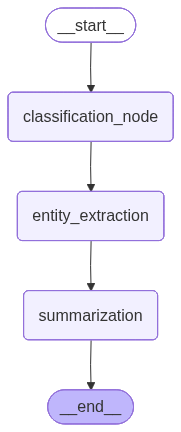

✅ 시각화 완료!


In [8]:
print("🎨 워크플로우 시각화 중...\n")

try:
    # get_graph(): 컴파일된 앱에서 그래프 구조 추출
    # draw_mermaid_png(): Mermaid 문법으로 PNG 이미지 생성
    # MermaidDrawMethod.API: Mermaid API를 사용하여 렌더링
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
    print("✅ 시각화 완료!")
except Exception as e:
    print(f"⚠️ 시각화 실패: {e}")
    print("   (인터넷 연결을 확인하거나 Mermaid API 접근을 확인하세요)")

### 🎯 Mermaid 문법 간단 설명

```mermaid
graph TD
    START --> classification_node
    classification_node --> entity_extraction
    entity_extraction --> summarization
    summarization --> END
```

- `graph TD`: Top-Down 방향 그래프
- `-->`: 화살표 (흐름 방향)
- 각 줄은 하나의 연결을 나타냄

## 🚀 7단계: 워크플로우 실행 및 테스트

### invoke() 메서드

`app.invoke(state_input)`는 워크플로우를 실행하는 메서드입니다.

**실행 과정:**
1. 입력 상태를 받습니다
2. 시작점(entry point)부터 노드를 순차적으로 실행합니다
3. 각 노드가 상태를 업데이트합니다
4. END 노드에 도달하면 최종 상태를 반환합니다

### 예제 텍스트 선택

OpenAI의 GPT-4 발표 관련 텍스트를 사용합니다.
- 명확한 주제
- 여러 개체명 포함
- 요약하기 적절한 길이

In [9]:
print("🚀 워크플로우 실행 시작...\n")
print("="*60)

# ==================== 테스트 데이터 준비 ====================
sample_text = """
OpenAI는 GPT-4 모델을 발표했습니다. 이는 다양한 전문 벤치마크에서 
인간 수준의 성능을 보이는 대규모 멀티모달 모델입니다. GPT-4는 AI 시스템의 
정렬과 안전성을 개선하기 위해 개발되었습니다. 또한 이전 버전인 GPT-3보다 
더 효율적이고 확장 가능하도록 설계되었습니다. GPT-4 모델은 앞으로 몇 달 내에 
출시될 예정이며, 연구 및 개발 목적으로 대중에게 공개될 것입니다.
"""

# 입력 상태 생성
# text 필드만 채우고, 나머지는 각 노드가 채웁니다
state_input = {"text": sample_text}

print("📄 입력 텍스트:")
print(sample_text)
print("\n" + "="*60)

# ==================== 워크플로우 실행 ====================
print("\n⚙️ 워크플로우 실행 중...\n")

# invoke()로 워크플로우 실행
# 내부적으로 각 노드가 순차적으로 실행됩니다
result = app.invoke(state_input)

# ==================== 결과 출력 ====================
print("\n" + "="*60)
print("✅ 워크플로우 실행 완료!")
print("="*60)

print("\n📊 최종 결과:\n")

print("1️⃣ 텍스트 분류:")
print(f"   {result['classification']}")
print()

print("2️⃣ 추출된 개체명:")
for i, entity in enumerate(result['entities'], 1):
    print(f"   {i}. {entity}")
print()

print("3️⃣ 요약:")
print(f"   {result['summary']}")
print()

print("="*60)

🚀 워크플로우 실행 시작...

📄 입력 텍스트:

OpenAI는 GPT-4 모델을 발표했습니다. 이는 다양한 전문 벤치마크에서 
인간 수준의 성능을 보이는 대규모 멀티모달 모델입니다. GPT-4는 AI 시스템의 
정렬과 안전성을 개선하기 위해 개발되었습니다. 또한 이전 버전인 GPT-3보다 
더 효율적이고 확장 가능하도록 설계되었습니다. GPT-4 모델은 앞으로 몇 달 내에 
출시될 예정이며, 연구 및 개발 목적으로 대중에게 공개될 것입니다.



⚙️ 워크플로우 실행 중...


🔍 [노드 1] 텍스트 분류 시작...
   ✅ 분류 완료: News (뉴스)

🏢 [노드 2] 개체명 추출 시작...
   ✅ 추출 완료: 3개 개체명 발견
      1. OpenAI
      2. GPT-4
      3. GPT-3

📝 [노드 3] 텍스트 요약 시작...
   ✅ 요약 완료
   📄 OpenAI는 인간 수준의 성능을 보이는 대규모 멀티모달 모델 GPT-4를 발표하고, 이를 통해 AI 시스템의 정렬과 안전성을 개선하며, 몇 달 내에 연구 및 개발 목적으로 대중에게 공개할 예정입니다.

✅ 워크플로우 실행 완료!

📊 최종 결과:

1️⃣ 텍스트 분류:
   News (뉴스)

2️⃣ 추출된 개체명:
   1. OpenAI
   2. GPT-4
   3. GPT-3

3️⃣ 요약:
   OpenAI는 인간 수준의 성능을 보이는 대규모 멀티모달 모델 GPT-4를 발표하고, 이를 통해 AI 시스템의 정렬과 안전성을 개선하며, 몇 달 내에 연구 및 개발 목적으로 대중에게 공개할 예정입니다.



### 🔍 결과 분석

**예상 결과:**
- **분류**: News (뉴스 형식의 발표문)
- **개체명**: OpenAI, GPT-4, GPT-3 등
- **요약**: GPT-4의 주요 특징과 출시 계획

### 💡 실행 흐름 이해하기

```python
state_input = {"text": "..."}  # 초기 상태
    ↓
classification_node(state)  # {"classification": "News"} 추가
    ↓
entity_extraction_node(state)  # {"entities": [...]} 추가
    ↓
summarization_node(state)  # {"summary": "..."} 추가
    ↓
result = {  # 최종 상태
    "text": "...",
    "classification": "News",
    "entities": [...],
    "summary": "..."
}
```

## 🧪 8단계: 커스텀 테스트

### 직접 테스트해보기

아래 셀에서 `your_text` 변수에 원하는 텍스트를 넣고 실행해보세요!

In [10]:
# ==================== 여기에 여러분의 텍스트를 입력하세요! ====================
your_text = """
여기에 분석하고 싶은 텍스트를 입력하세요.
예: 뉴스 기사, 블로그 글, 연구 논문 초록 등
"""

# ==================== 실행 ====================
print("🔬 커스텀 텍스트 분석 시작...\n")
print("="*60)

custom_state = {"text": your_text}
custom_result = app.invoke(custom_state)

print("📊 분석 결과:\n")
print(f"분류: {custom_result['classification']}")
print(f"개체명: {', '.join(custom_result['entities'])}")
print(f"요약: {custom_result['summary']}")
print("\n" + "="*60)

🔬 커스텀 텍스트 분석 시작...


🔍 [노드 1] 텍스트 분류 시작...
   ✅ 분류 완료: Other (기타)

🏢 [노드 2] 개체명 추출 시작...
   ✅ 추출 완료: 3개 개체명 발견
      1. 죄송하지만
      2. 분석할 텍스트가 제공되지 않았습니다. 분석하고 싶은 텍스트를 입력해 주시면
      3. 그에 따라 주요 개체명을 추출해 드리겠습니다.

📝 [노드 3] 텍스트 요약 시작...
   ✅ 요약 완료
   📄 분석하고 싶은 텍스트를 입력하세요.
📊 분석 결과:

분류: Other (기타)
개체명: 죄송하지만, 분석할 텍스트가 제공되지 않았습니다. 분석하고 싶은 텍스트를 입력해 주시면, 그에 따라 주요 개체명을 추출해 드리겠습니다.
요약: 분석하고 싶은 텍스트를 입력하세요.



## 📚 9단계: 심화 학습 - 상태 추적

### 각 노드의 중간 결과 확인하기

워크플로우의 각 단계를 개별적으로 실행하여 상태 변화를 관찰할 수 있습니다.

In [11]:
print("🔍 상태 변화 추적 실습\n")
print("="*60)

# 초기 상태
state = {"text": sample_text}
print("0️⃣ 초기 상태:")
print(f"   text: {state['text'][:50]}...")
print()

# 노드 1 실행
result1 = classification_node(state)
state.update(result1)  # 상태 업데이트
print("\n1️⃣ classification_node 실행 후:")
print(f"   classification: {state.get('classification', 'N/A')}")
print()

# 노드 2 실행
result2 = entity_extraction_node(state)
state.update(result2)
print("\n2️⃣ entity_extraction_node 실행 후:")
print(f"   entities: {state.get('entities', [])}")
print()

# 노드 3 실행
result3 = summarization_node(state)
state.update(result3)
print("\n3️⃣ summarization_node 실행 후:")
print(f"   summary: {state.get('summary', 'N/A')}")
print()

print("="*60)
print("✅ 모든 노드 실행 완료!")
print("\n💡 Tip: 각 노드가 상태의 특정 필드만 업데이트하는 것을 확인하세요!")

🔍 상태 변화 추적 실습

0️⃣ 초기 상태:
   text: 
OpenAI는 GPT-4 모델을 발표했습니다. 이는 다양한 전문 벤치마크에서 
인간 수준...


🔍 [노드 1] 텍스트 분류 시작...
   ✅ 분류 완료: News (뉴스)

1️⃣ classification_node 실행 후:
   classification: News (뉴스)


🏢 [노드 2] 개체명 추출 시작...
   ✅ 추출 완료: 3개 개체명 발견
      1. OpenAI
      2. GPT-4
      3. GPT-3

2️⃣ entity_extraction_node 실행 후:
   entities: ['OpenAI', 'GPT-4', 'GPT-3']


📝 [노드 3] 텍스트 요약 시작...
   ✅ 요약 완료
   📄 OpenAI는 인간 수준의 성능을 보이는 대규모 멀티모달 모델 GPT-4를 발표하고, 이를 통해 AI 시스템의 정렬과 안전성을 개선하며, 몇 달 내에 연구 및 개발 목적으로 대중에게 공개할 예정입니다.

3️⃣ summarization_node 실행 후:
   summary: OpenAI는 인간 수준의 성능을 보이는 대규모 멀티모달 모델 GPT-4를 발표하고, 이를 통해 AI 시스템의 정렬과 안전성을 개선하며, 몇 달 내에 연구 및 개발 목적으로 대중에게 공개할 예정입니다.

✅ 모든 노드 실행 완료!

💡 Tip: 각 노드가 상태의 특정 필드만 업데이트하는 것을 확인하세요!


## 🎓 10단계: 핵심 개념 정리

### LangGraph의 핵심 요소

| 요소 | 설명 | 예시 |
|------|------|------|
| **State** | 워크플로우 전체에서 공유되는 데이터 | `{"text": "...", "classification": "News"}` |
| **Node** | 특정 작업을 수행하는 함수 | `classification_node(state)` |
| **Edge** | 노드 간의 연결 (흐름) | `A → B → C` |
| **Graph** | 노드와 엣지로 구성된 전체 워크플로우 | `StateGraph(State)` |

### 주요 메서드

```python
# 그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("node_name", function)

# 시작점 설정
workflow.set_entry_point("node_name")

# 엣지 추가
workflow.add_edge("from_node", "to_node")

# 컴파일
app = workflow.compile()

# 실행
result = app.invoke(input_state)
```

### 디자인 패턴

1. **파이프라인 패턴**: A → B → C (순차적 처리)
2. **병렬 처리**: A → [B, C, D] → E (동시 실행)
3. **조건부 라우팅**: A → (조건) → B or C (분기)
4. **루프**: A → B → A (반복)

## 🚀 다음 단계

### 1. 노드 추가하기
- **감정 분석**: 텍스트의 긍정/부정 판단
- **키워드 추출**: 주요 키워드 추출
- **번역**: 다른 언어로 번역

### 2. 조건부 라우팅 구현
```python
# 분류 결과에 따라 다른 경로로 라우팅
def route_by_classification(state):
    if state["classification"] == "News":
        return "news_handler"
    else:
        return "general_handler"
```

### 3. 병렬 처리 구현
```python
# 개체명 추출과 감정 분석을 동시에 실행
workflow.add_edge("classification", "entity_extraction")
workflow.add_edge("classification", "sentiment_analysis")
```

### 4. 에러 처리 추가
```python
def safe_node(state):
    try:
        # 작업 수행
        pass
    except Exception as e:
        return {"error": str(e)}
```

### 5. 스트리밍 결과
```python
# 각 노드의 결과를 실시간으로 출력
for output in app.stream(state_input):
    print(output)
```

## 💡 학습 팁

### 이해를 위한 3단계

1. **읽기**: 코드를 천천히 읽으며 각 부분의 역할을 이해합니다
2. **실행**: 셀을 하나씩 실행하며 결과를 확인합니다
3. **수정**: 코드를 변경해보며 동작을 실험합니다

### 실습 과제

1. ✏️ 새로운 노드를 추가해보세요 (예: 감정 분석)
2. 🔄 노드의 순서를 변경해보세요
3. 🎨 다른 프롬프트로 결과가 어떻게 달라지는지 확인해보세요
4. 📊 여러 개의 텍스트를 배치로 처리해보세요

### 디버깅 팁

```python
# 각 노드에 print 문 추가
def my_node(state):
    print(f"현재 상태: {state}")
    # ...
    return result

# 에러 발생 시 상태 확인
try:
    result = app.invoke(state_input)
except Exception as e:
    print(f"에러: {e}")
    print(f"현재 상태: {state_input}")
```

## 🎯 결론

축하합니다! 🎉 이제 여러분은:

✅ LangGraph의 핵심 개념을 이해했습니다
✅ 상태 기반 워크플로우를 구축할 수 있습니다
✅ 노드와 엣지로 복잡한 파이프라인을 만들 수 있습니다
✅ AI 모델을 워크플로우에 통합할 수 있습니다
✅ 결과를 시각화하고 분석할 수 있습니다

### 더 학습하기

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)
- [LangChain 문서](https://python.langchain.com/)
- [예제 모음](https://github.com/langchain-ai/langgraph/tree/main/examples)

### 질문이 있으시면

- GitHub Issues
- Discord 커뮤니티
- Stack Overflow

**Happy Coding! 🚀**